In [ ]:
import pandas as pd
import torch
import random
from transformers import BertTokenizer, BertForNextSentencePrediction
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

df = pd.read_csv('//content/train.csv')
df = df.sample(n=200, random_state=42)  # Limit for faster training
sentences = df['question_text'].dropna().tolist()

sentence1 = []
sentence2 = []
labels = []

for i in range(len(sentences) - 1):
    sentence1.append(sentences[i])
    sentence2.append(sentences[i + 1])
    labels.append(1)

for _ in range(len(sentences) - 1):
    s1 = random.choice(sentences)
    s2 = random.choice(sentences)
    sentence1.append(s1)
    sentence2.append(s2)
    labels.append(0)

combined_df = pd.DataFrame({
    'sentence1': sentence1,
    'sentence2': sentence2,
    'label': labels
})

class NSPDataset(Dataset):
    def __init__(self, sentence1, sentence2, labels, tokenizer, max_len=64):
        self.sentence1 = sentence1
        self.sentence2 = sentence2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence1)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.sentence1[idx],
            self.sentence2[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoded['input_ids'].squeeze()
        attention_mask = encoded['attention_mask'].squeeze()
        token_type_ids = encoded['token_type_ids'].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'labels': label
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

train_s1, val_s1, train_s2, val_s2, train_labels, val_labels = train_test_split(
    combined_df['sentence1'], combined_df['sentence2'], combined_df['label'],
    test_size=0.2, random_state=42
)

train_dataset = NSPDataset(train_s1.tolist(), train_s2.tolist(), train_labels.tolist(), tokenizer)
val_dataset = NSPDataset(val_s1.tolist(), val_s2.tolist(), val_labels.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(1):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader)}")

model.save_pretrained('./nsp_model_fast')
tokenizer.save_pretrained('./nsp_model_fast')


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1:  70%|███████   | 28/40 [00:03<00:01,  8.54it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been re

Epoch 1 Loss: 1.434625089223846


('./nsp_model_fast/tokenizer_config.json',
 './nsp_model_fast/special_tokens_map.json',
 './nsp_model_fast/vocab.txt',
 './nsp_model_fast/added_tokens.json')

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Validation Accuracy: 48.75%


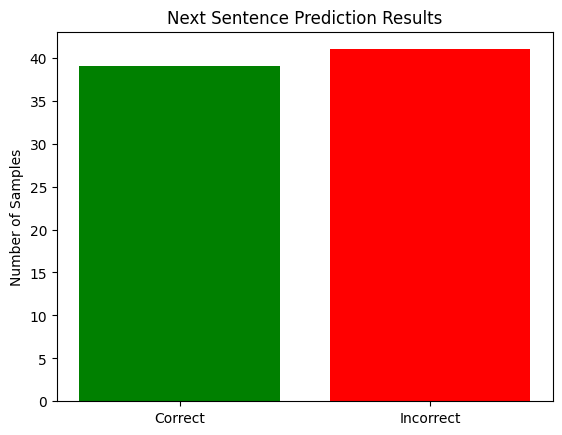

In [ ]:
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

correct_count = correct
incorrect_count = total - correct

plt.bar(['Correct', 'Incorrect'], [correct_count, incorrect_count], color=['green', 'red'])
plt.title('Next Sentence Prediction Results')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction
import random

model_path = './nsp_model_fast'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForNextSentencePrediction.from_pretrained(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

df = pd.read_csv('/content/train.csv')
sentences = df['question_text'].dropna().tolist()
source_sentence = random.choice(sentences)
print(f"\n{source_sentence}\n")

candidates = random.sample(sentences, 5)
scores = []

for candidate in candidates:
    encoding = tokenizer(source_sentence, candidate, return_tensors='pt', truncation=True, padding='max_length', max_length=64)
    for k in encoding:
        encoding[k] = encoding[k].to(device)
    outputs = model(**encoding)
    logits = outputs.logits
    prob = torch.softmax(logits, dim=1)
    is_next_score = prob[0][0].item()
    scores.append((candidate, is_next_score))

sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

for i, (text, score) in enumerate(sorted_scores, 1):
    print(f"{i}. (Score: {score:.4f}) {text}")


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



My mother has always said that nobody will ever love me (romantically) because of my attitude, whenever we argue. It really hurts me. Do you think that what she says will really be true?

1. (Score: 0.4871) Has there ever been a single terrible performance that ruined a television show for you?
2. (Score: 0.4432) What is the quickest way to boost your Snapchat points?
3. (Score: 0.4359) What book should I read to learn how to lead? (Something like “art of war- Sun Tzu”, in terms of length and contenents)
4. (Score: 0.3918) In "couple body language", what does it mean if a man hugs you around the lower waist and/or butt with his hand near or on it?
5. (Score: 0.1750) What would be the forecast of Asia Pacific Beer market and which are leading players?



SOURCE:
What are 5 tips to have a successful telephone interview?

1. (Score: 0.4221) How can I connect with my old college mates?
2. (Score: 0.4160) What are examples of big data projects that Silicon Valley works on?
3. (Score: 0.4107) How does coffee make you poop?
4. (Score: 0.3657) What is the production process of the Jameson Irish whiskey?
5. (Score: 0.3537) Do you believe there is other life forms in the universe and why?


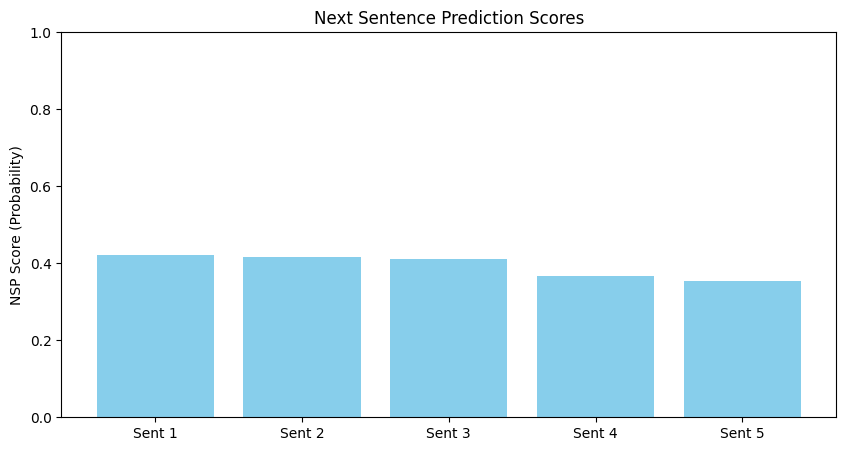

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction
import random
import matplotlib.pyplot as plt

model_path = './nsp_model_fast'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForNextSentencePrediction.from_pretrained(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

df = pd.read_csv('/content/train.csv')
sentences = df['question_text'].dropna().tolist()
source_sentence = random.choice(sentences)
print(f"\nSOURCE:\n{source_sentence}\n")

candidates = random.sample(sentences, 5)
scores = []

for candidate in candidates:
    encoding = tokenizer(source_sentence, candidate, return_tensors='pt', truncation=True, padding='max_length', max_length=64)
    for k in encoding:
        encoding[k] = encoding[k].to(device)
    outputs = model(**encoding)
    prob = torch.softmax(outputs.logits, dim=1)
    is_next_score = prob[0][0].item()
    scores.append((candidate, is_next_score))

sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

for i, (text, score) in enumerate(sorted_scores, 1):
    print(f"{i}. (Score: {score:.4f}) {text}")

texts = [f"Sent {i+1}" for i in range(5)]
values = [score for _, score in sorted_scores]

plt.figure(figsize=(10, 5))
plt.bar(texts, values, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("NSP Score (Probability)")
plt.title("Next Sentence Prediction Scores")
plt.show()
